1. 选定一个数据集

shape of monns: (10000, 2)


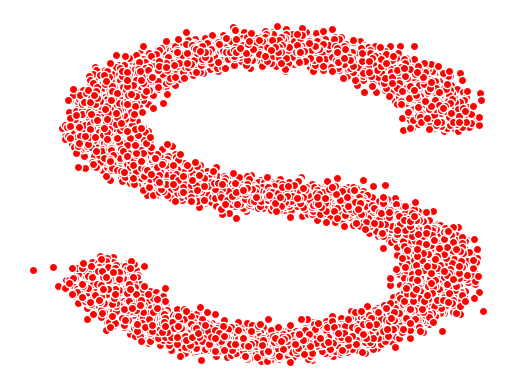

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
# from sklearn.datasets import make_moons, make_circles
import torch

# make_s_curve 用来生成 3D 的“S”形曲线数据集（非线性流形）
# 10**4 表示 10的4次方 = 10000；
# noise=0.1 表示加一点高斯噪声，使得曲线不是完美平滑，有一定扰动，更接近真实分布。
s_curve, _ = make_s_curve(10**4, noise=0.1)
# 保留了第 0 维（x）和第 2 维（z），形成一个二维平面图。
# 然后 除以 10 缩小比例，让图像范围变小、集中。
s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of monns:", np.shape(s_curve))

# 矩阵转置，方便解包。原本是(10000, 2)，现在变成了(2, 10000)
data = s_curve.T
fig, ax = plt.subplots()
# *data表示解包，相当于 data[0], data[1] ... data[9999]
ax.scatter(*data, color="red", edgecolor="white");
ax.axis("off")
plt.show()
plt.close()

dataset = torch.Tensor(s_curve).float()

2. 确定超参数的值

In [4]:
num_steps = 100  # 对于步骤，一开始可以由beta、分布的均值和标准差来共同确定

# 制定每一步的beta (每一步噪声的比例)
betas = torch.linspace(-6, 6, num_steps)  # 构造一个 [-6, 6] 的 100 步的均匀值
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5  # 映射到 (0,1) 区间, 再缩放到你想要的范围 1e-5 ~ 0.005

# 计算alpha、alpha_prod、alpha_previous、alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)  # p表示previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)  # KL散度会使用
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

# 判断所有图像的形状大小是否相等，防止上面参数写错
assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == \
one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape
print("ALL the same shape:", betas.shape)

ALL the same shape: torch.Size([100])


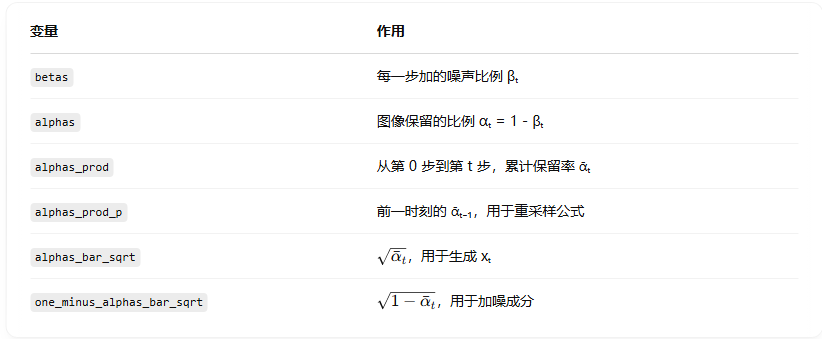

3. 确定扩散过程任意时刻的采样值

In [7]:
# 计算任意时刻的x的采样值，基于x_0和参数重整化技巧
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""

    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    # alphas_t = extract(alphas_bar_sqrt, t, x_0)  # 得到sqrt(alphas_bar[t]), x_0的作用是传入shape
    # aplhas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)  # 得到sqrt(1-alphas_bar[t])
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声

4. 演示原始数据分布加噪100步后的结果

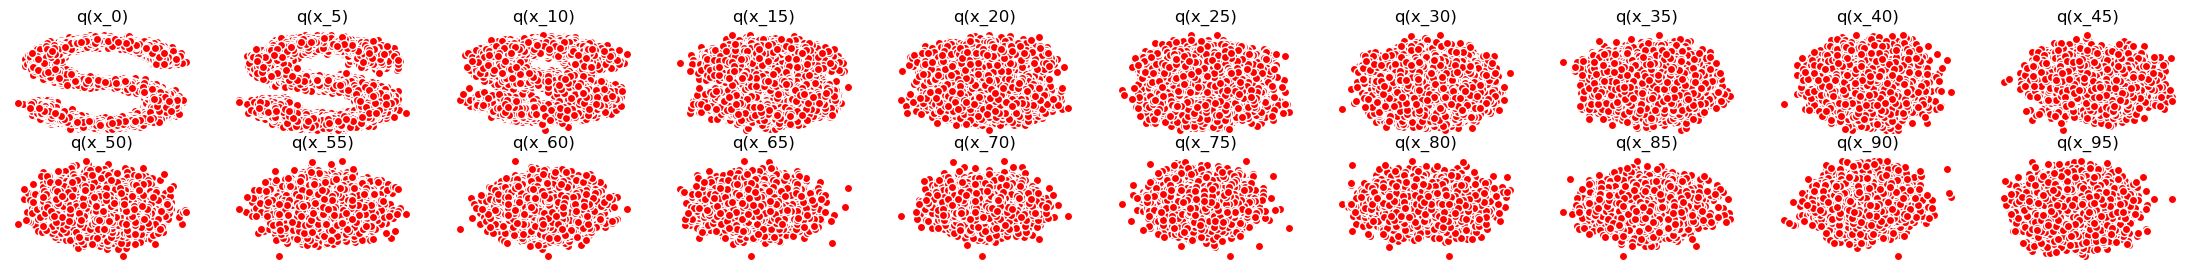

In [9]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color="blue")

# 共有10000个点，每个点包含两个坐标
# 生成100步以内，每隔5步加噪后的图像
for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]))  # 生成t时刻的采样数据
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j ,k].set_title(f'q(x_{str(i*num_steps//num_shows)})')

plt.show()
plt.close()

5. 编写拟合逆扩散过程的高斯分布模型

In [11]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )

        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)

        x = self.linears[-1](x)
        return x

6. 编写训练的误差函数

In [13]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机时刻t，为了覆盖到更多的t，
    # 先取了从偶数中随机取值 batch_size//2，然后 n_steps-1-t 从奇数中取值
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    # print(t.shape)

    a = alphas_bar_sqrt[t]  # x0的系数
    am1 = one_minus_alphas_bar_sqrt[t]  # eps的系数
    e = torch.randn_like(x_0)  # 随机生成噪音eps
    x = x_0 * a + e * am1  # 构造模型输入
    
    output = model(x, t.squeeze(-1))  # 送入模型，得到t时刻的随机噪声预测值
    return (e - output).square().mean()  # 与真实噪声一起计算误差，求平均值

7. 编写逆扩散采样函数

In [15]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从 x[T] 恢复 x[T-1], x[T-2], ..., x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从 x[T] 采样t时刻的重构值"""
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1-betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t *z
    return (sample)

8. 开始训练模型，并打印loss及中间的重构效果

Training model ...
tensor(0.7432, grad_fn=<MeanBackward0>)


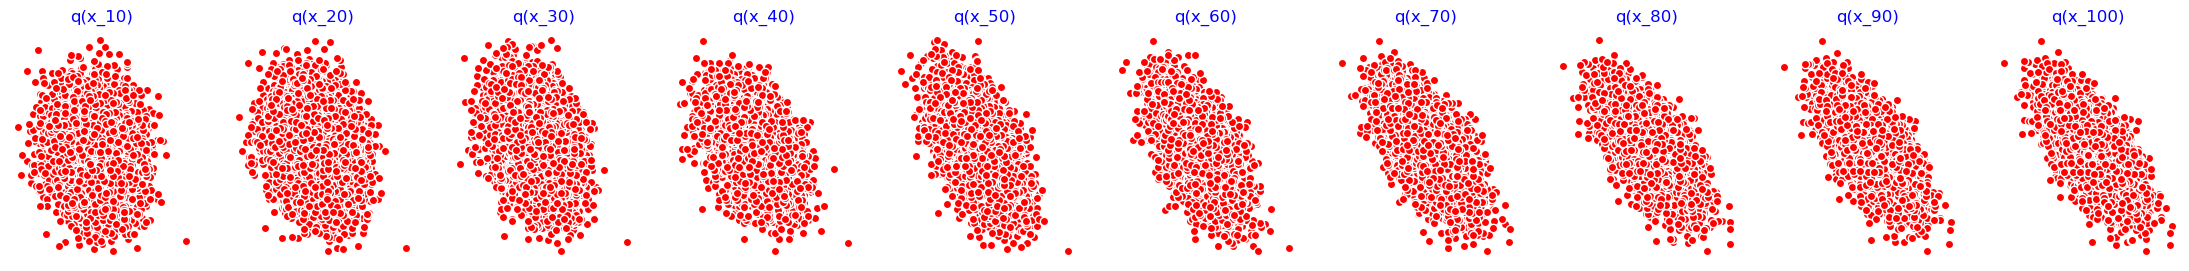

tensor(0.2574, grad_fn=<MeanBackward0>)


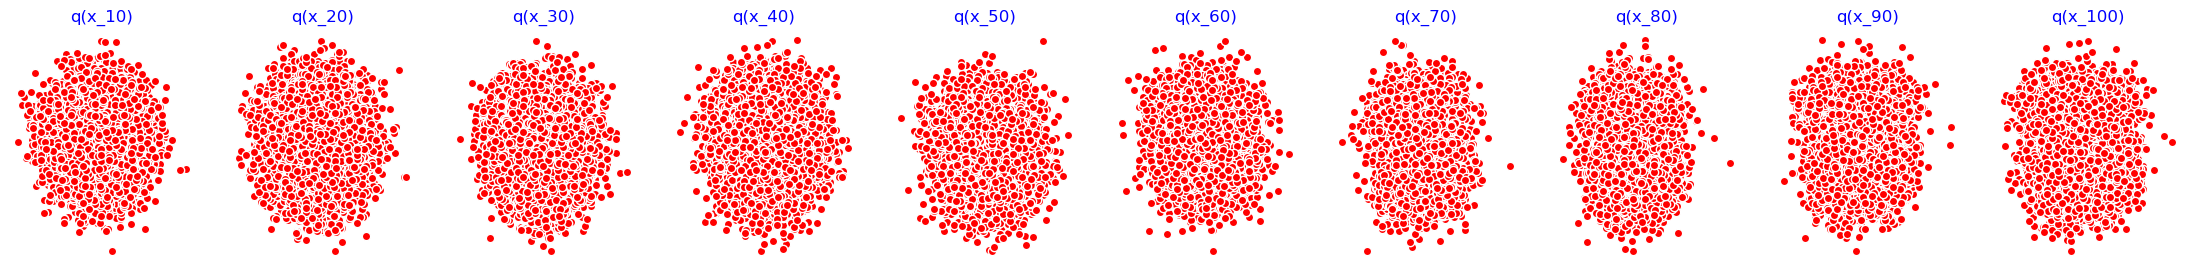

tensor(0.4550, grad_fn=<MeanBackward0>)


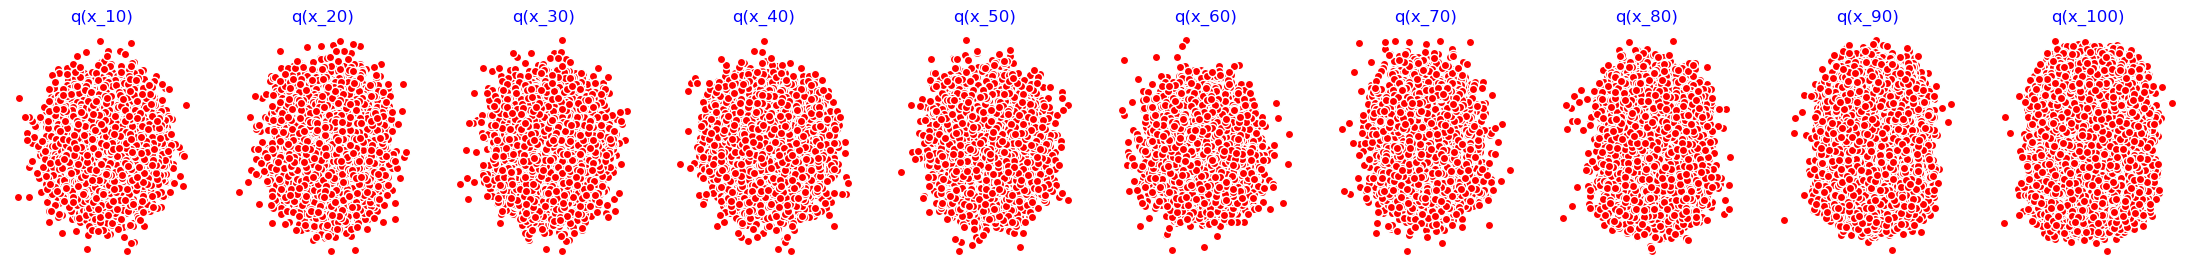

tensor(0.3830, grad_fn=<MeanBackward0>)


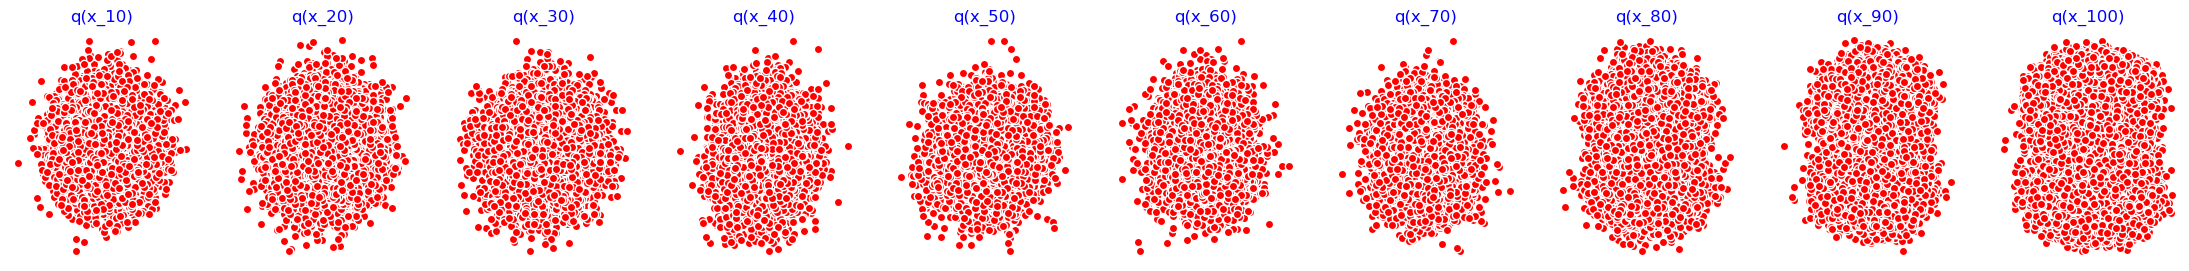

tensor(0.2768, grad_fn=<MeanBackward0>)


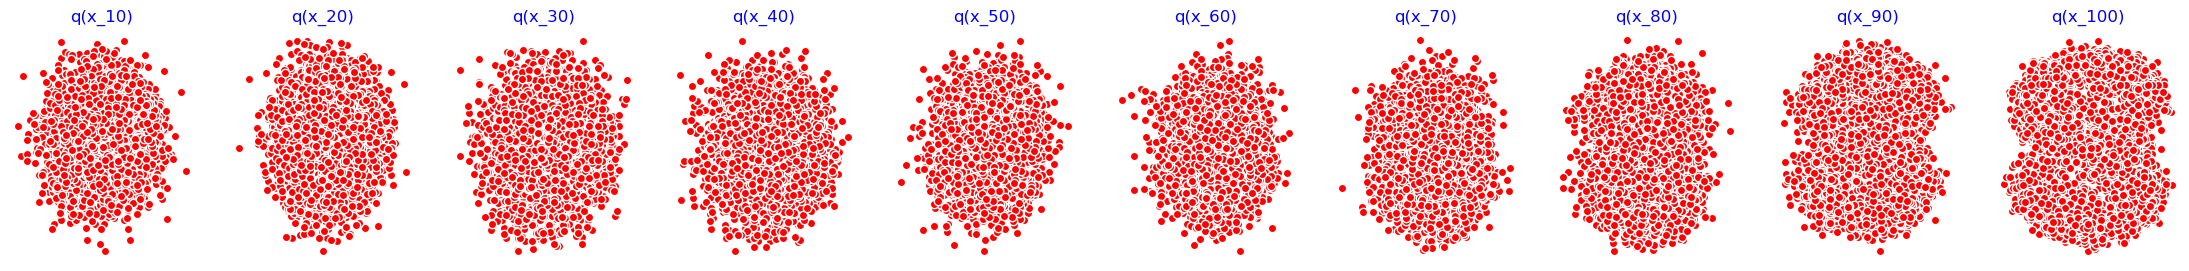

tensor(0.4933, grad_fn=<MeanBackward0>)


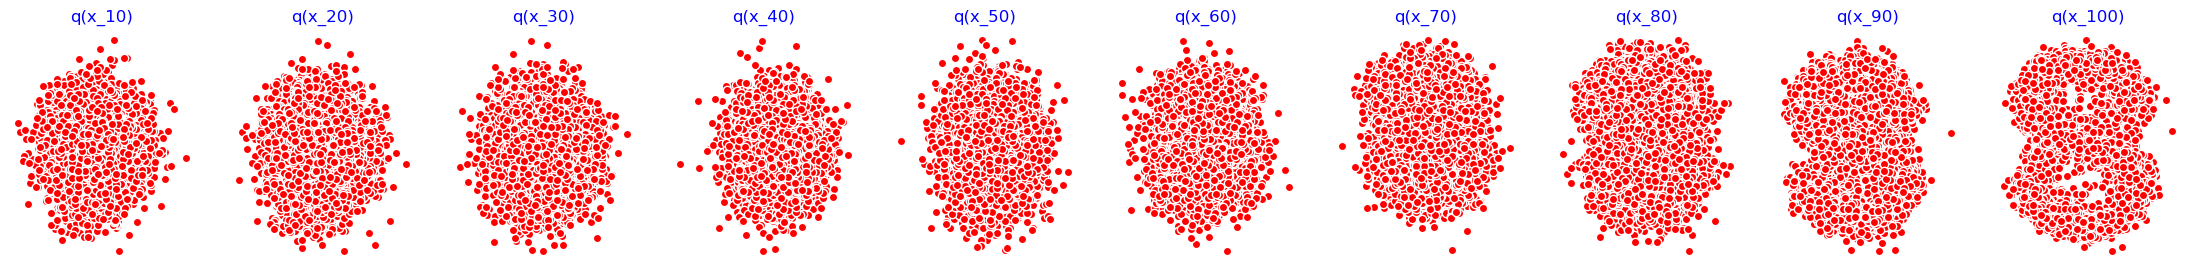

tensor(0.2107, grad_fn=<MeanBackward0>)


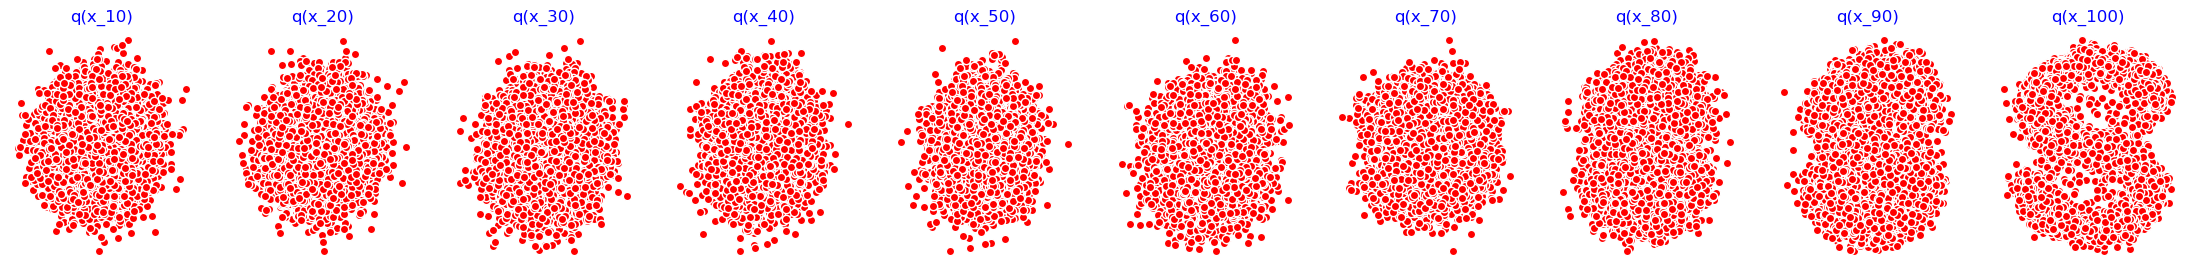

tensor(0.3364, grad_fn=<MeanBackward0>)


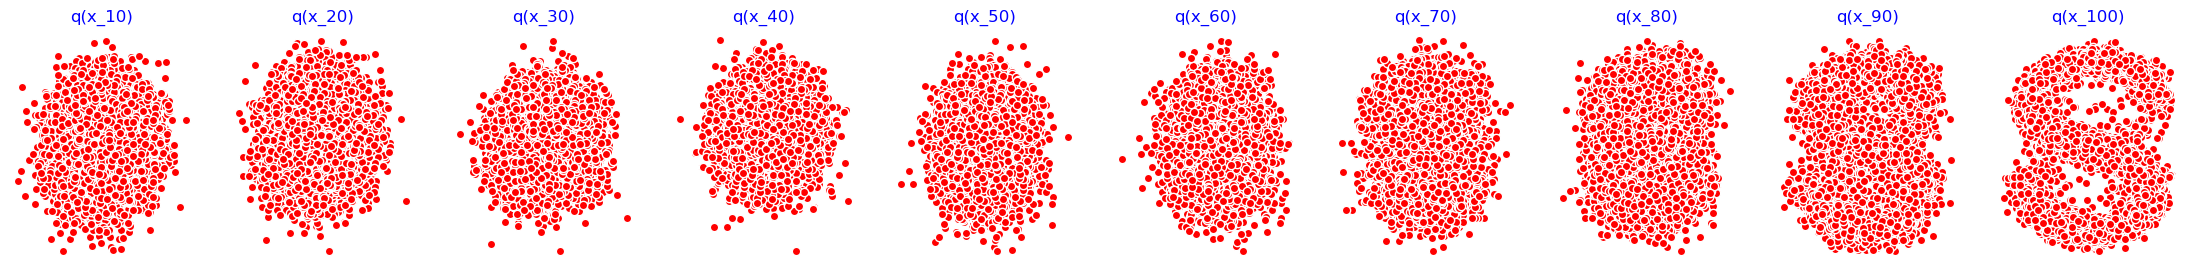

tensor(0.2595, grad_fn=<MeanBackward0>)


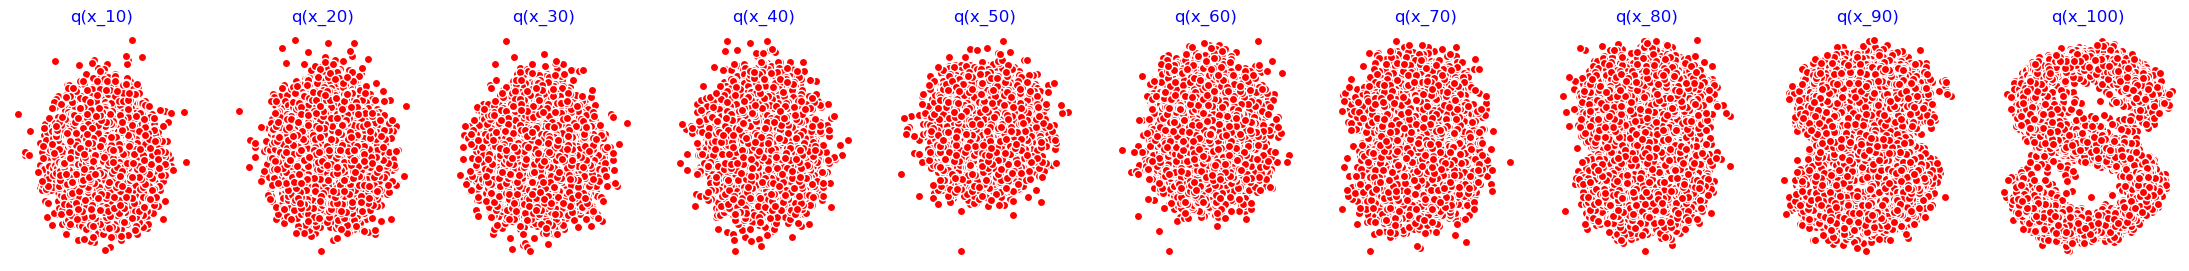

tensor(0.7461, grad_fn=<MeanBackward0>)


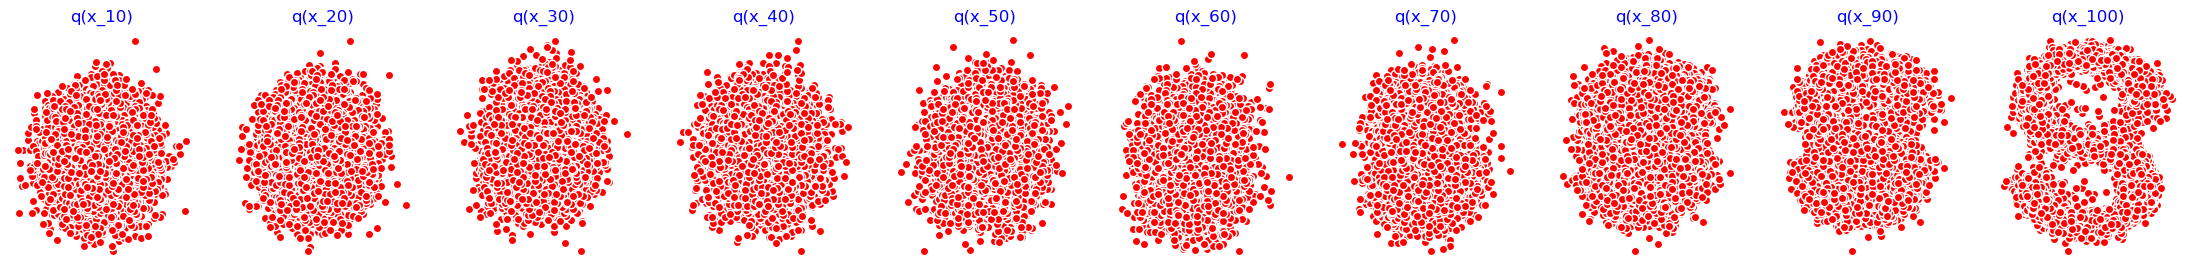

tensor(0.2545, grad_fn=<MeanBackward0>)


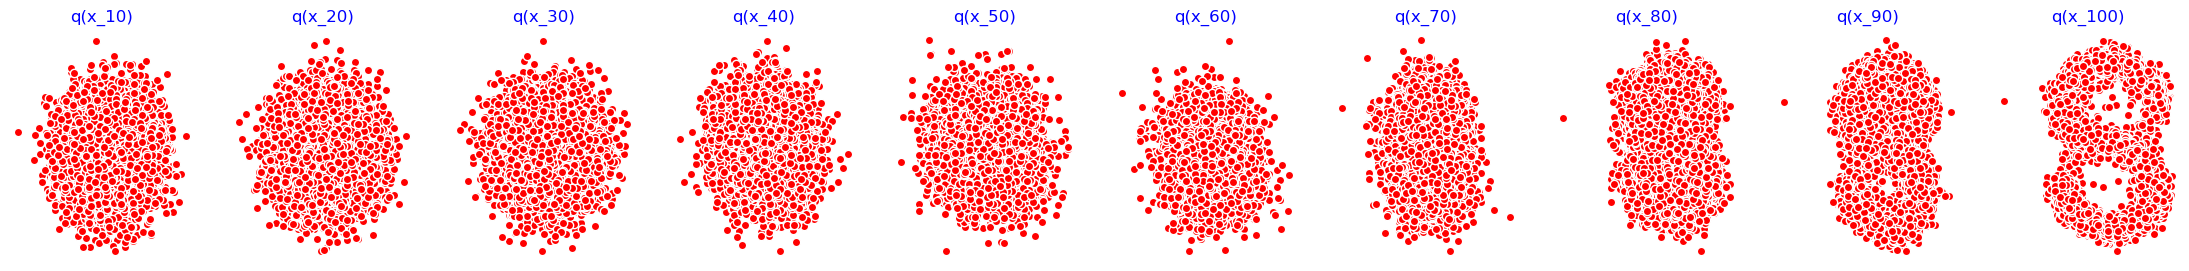

tensor(0.4093, grad_fn=<MeanBackward0>)


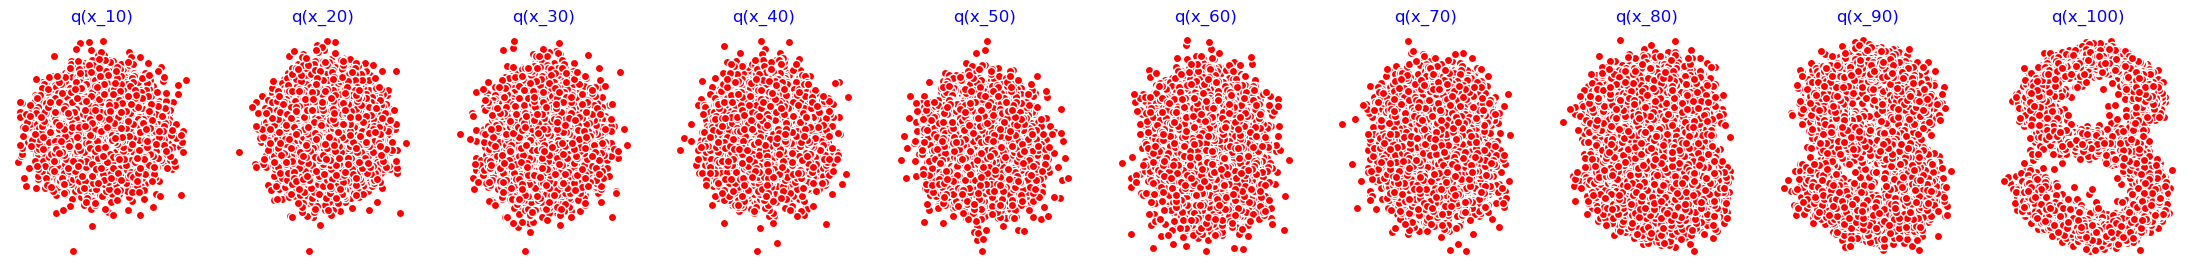

tensor(0.3653, grad_fn=<MeanBackward0>)


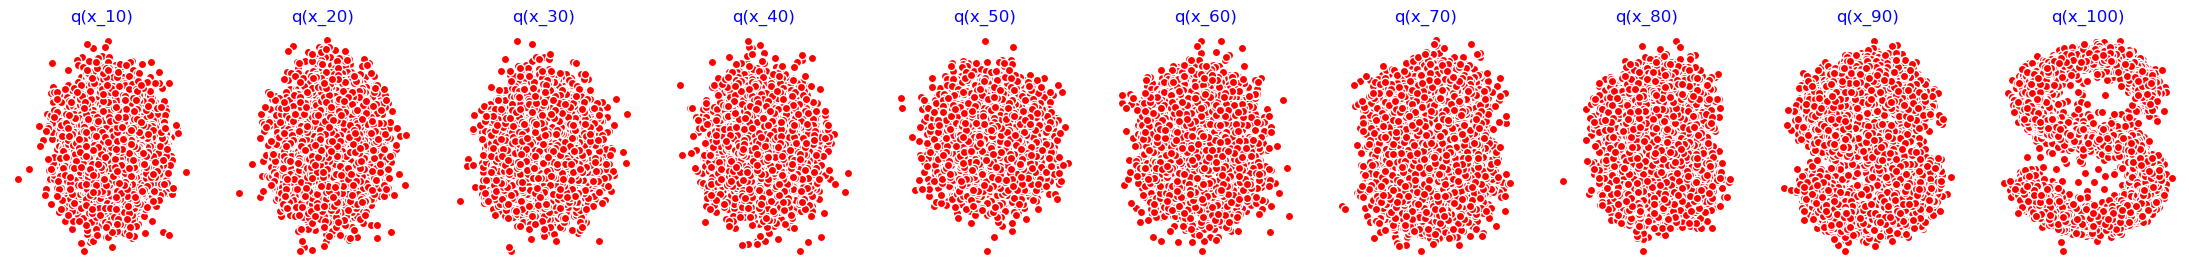

tensor(0.2393, grad_fn=<MeanBackward0>)


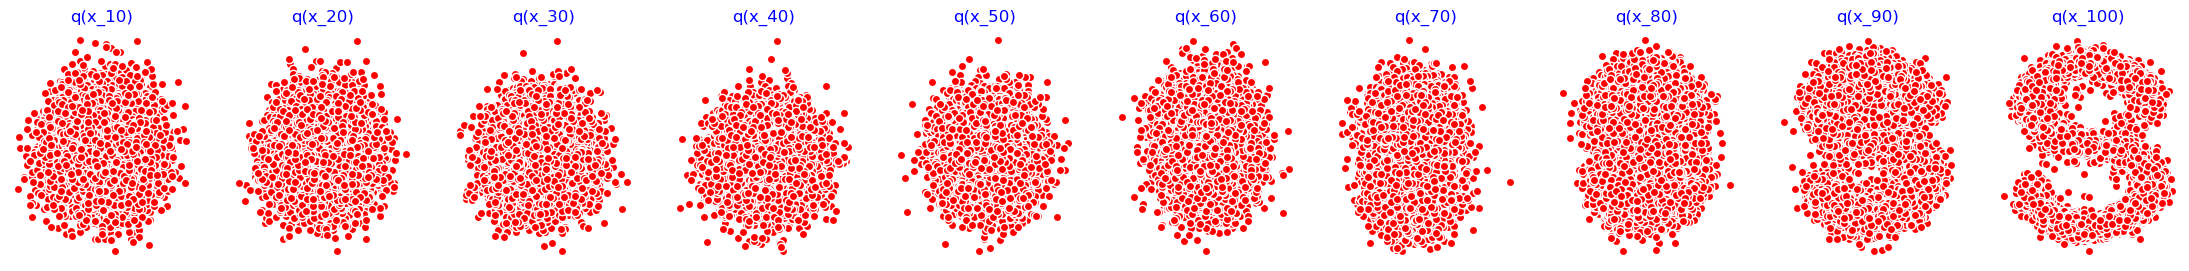

tensor(0.2460, grad_fn=<MeanBackward0>)


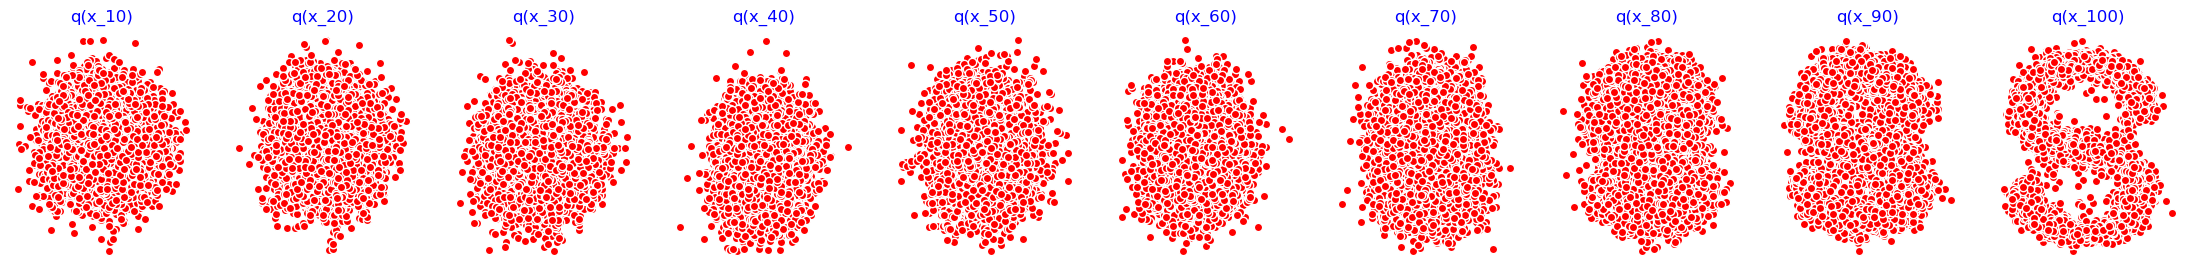

tensor(0.2441, grad_fn=<MeanBackward0>)


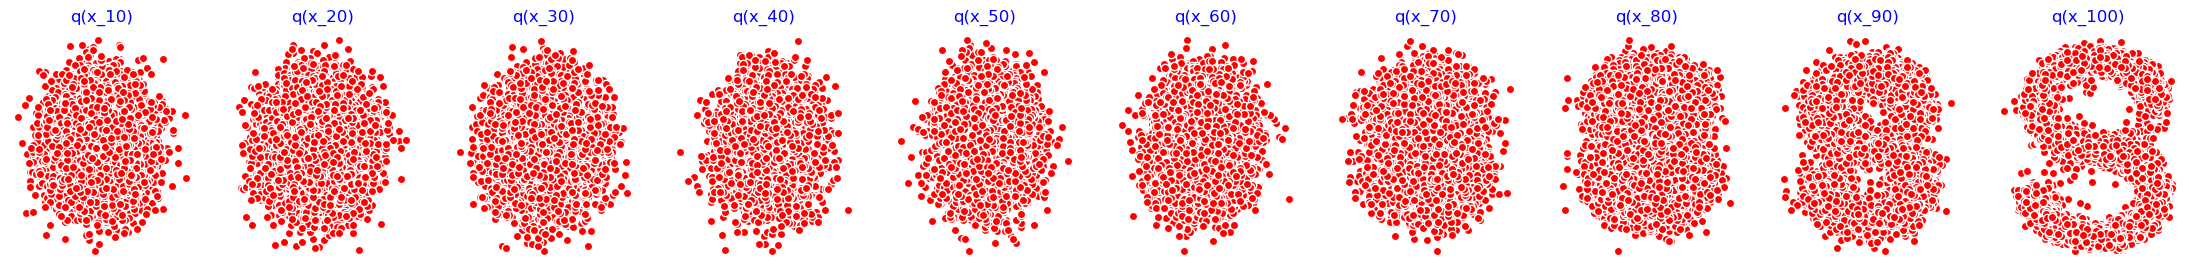

tensor(0.4974, grad_fn=<MeanBackward0>)


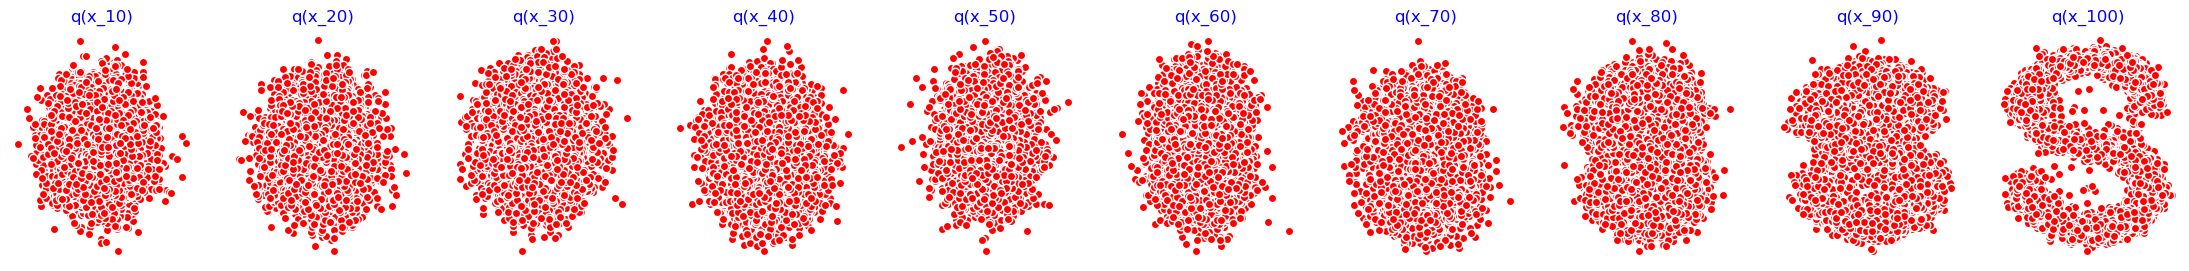

tensor(0.6696, grad_fn=<MeanBackward0>)


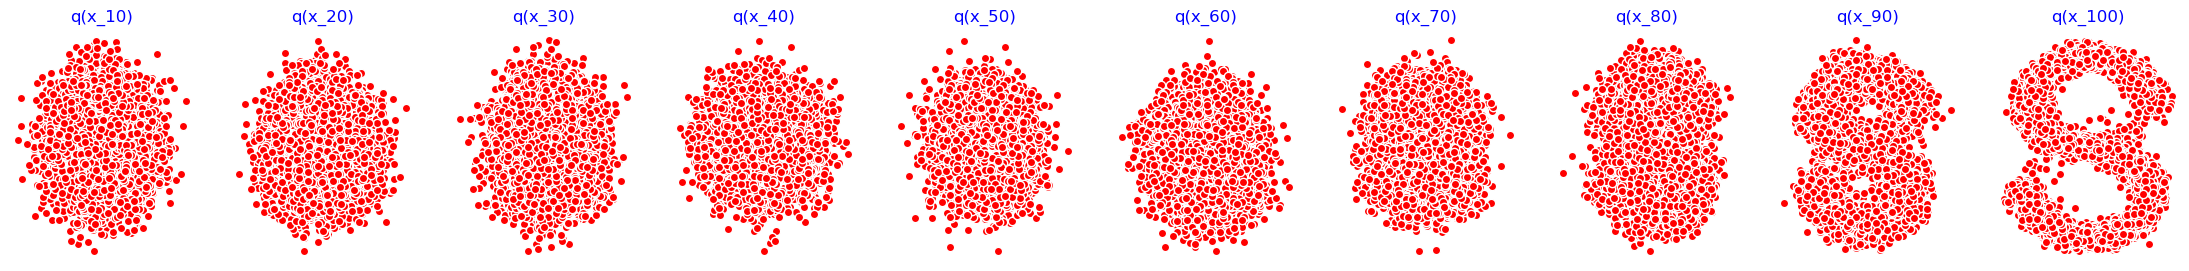

tensor(0.2426, grad_fn=<MeanBackward0>)


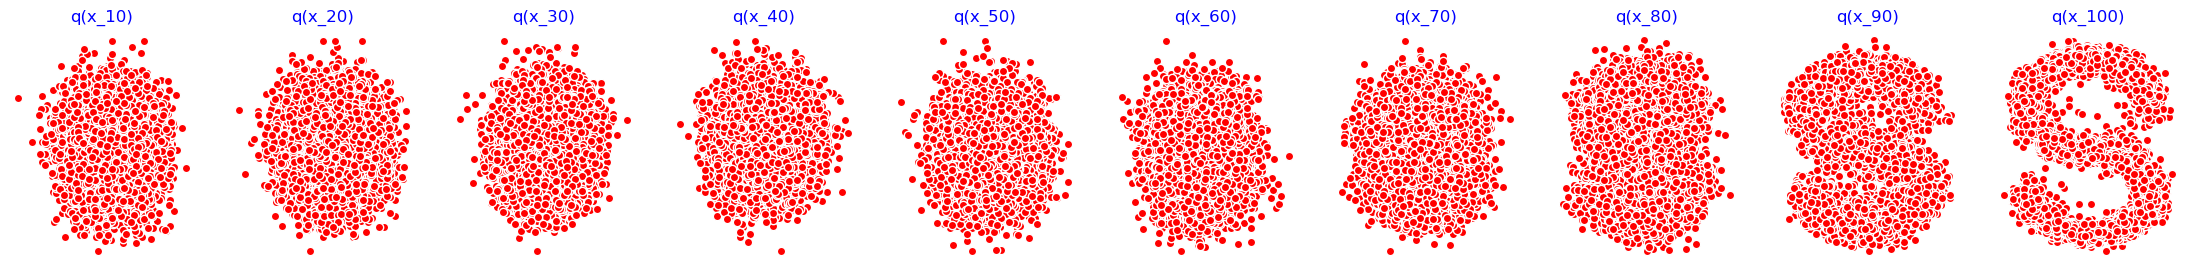

tensor(0.3702, grad_fn=<MeanBackward0>)


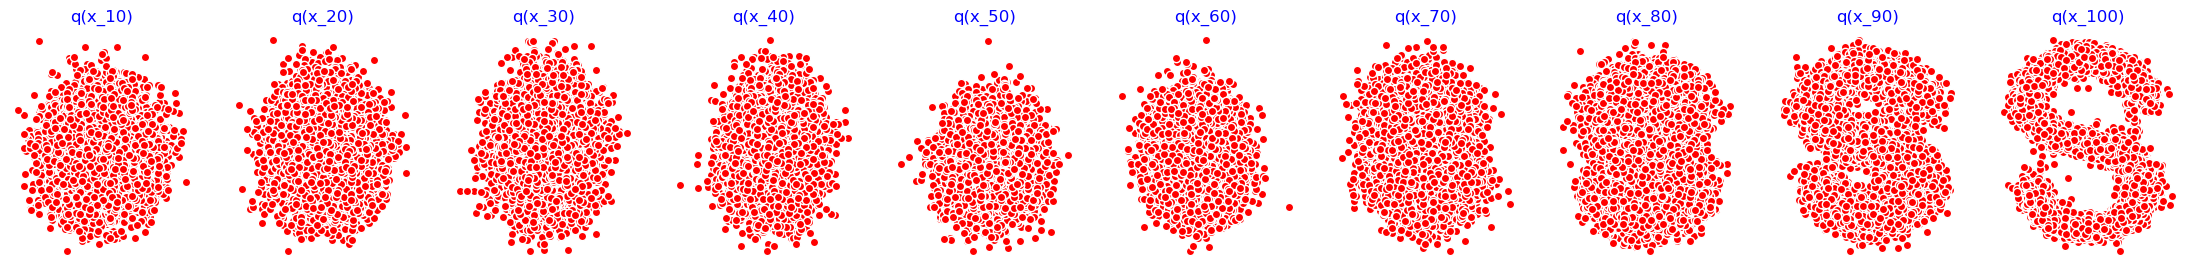

tensor(0.3688, grad_fn=<MeanBackward0>)


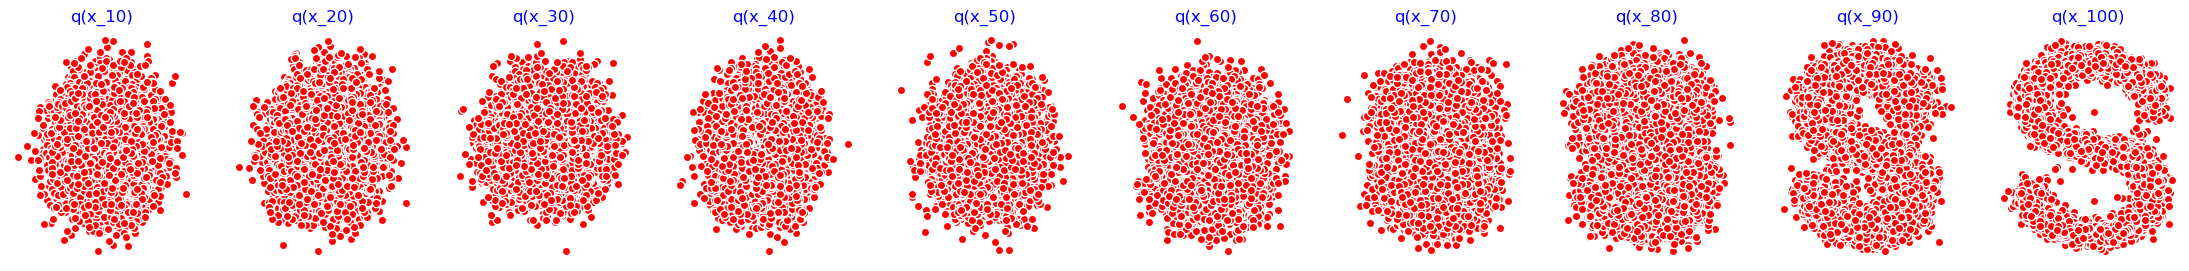

tensor(0.2591, grad_fn=<MeanBackward0>)


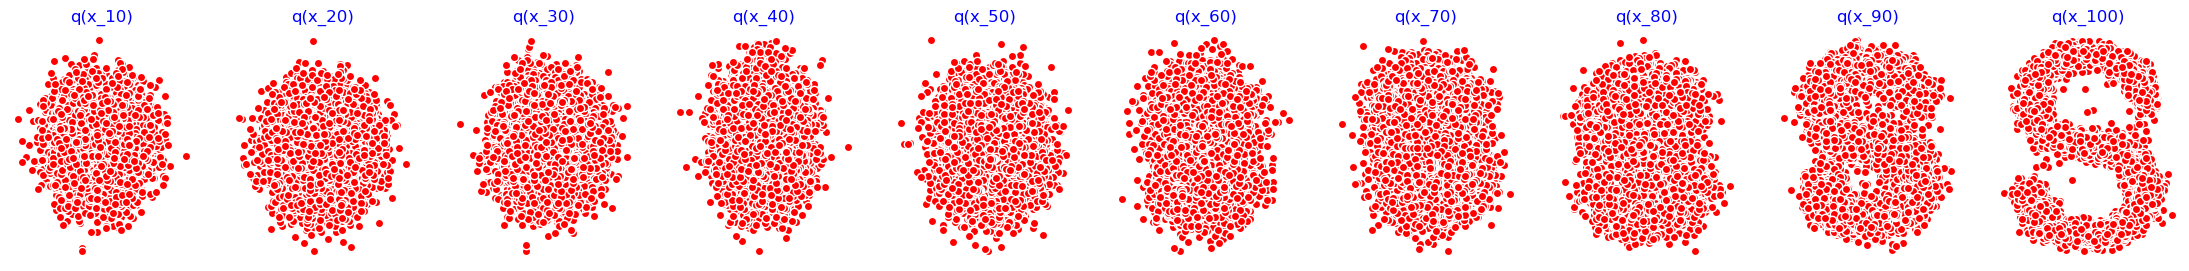

tensor(0.3762, grad_fn=<MeanBackward0>)


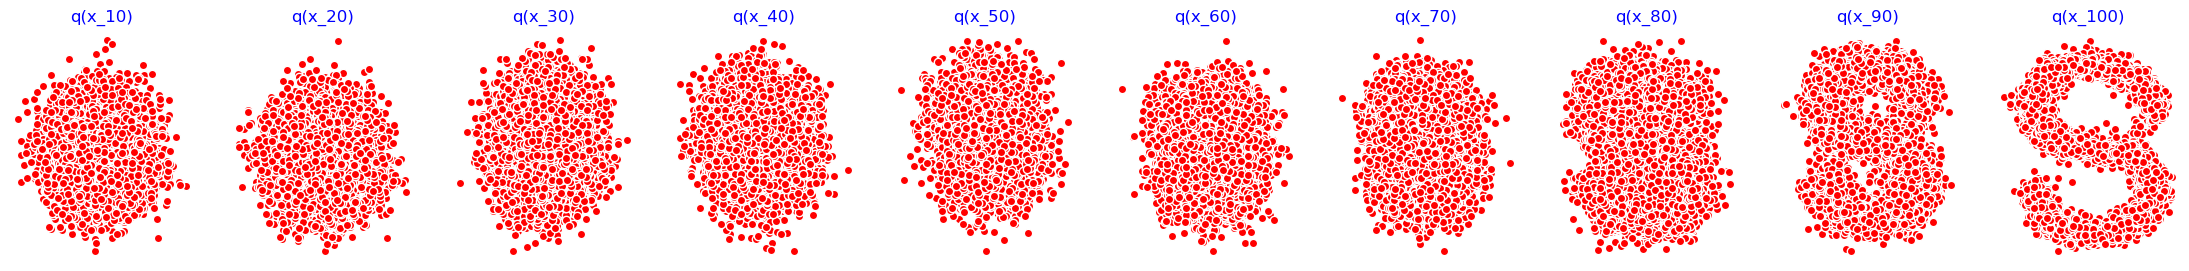

tensor(0.2393, grad_fn=<MeanBackward0>)


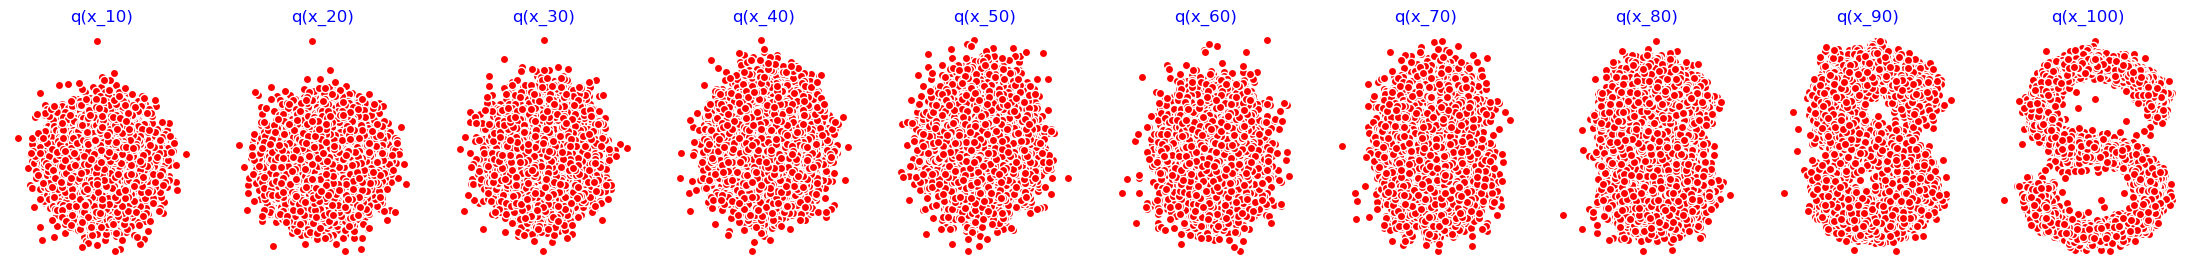

tensor(0.2872, grad_fn=<MeanBackward0>)


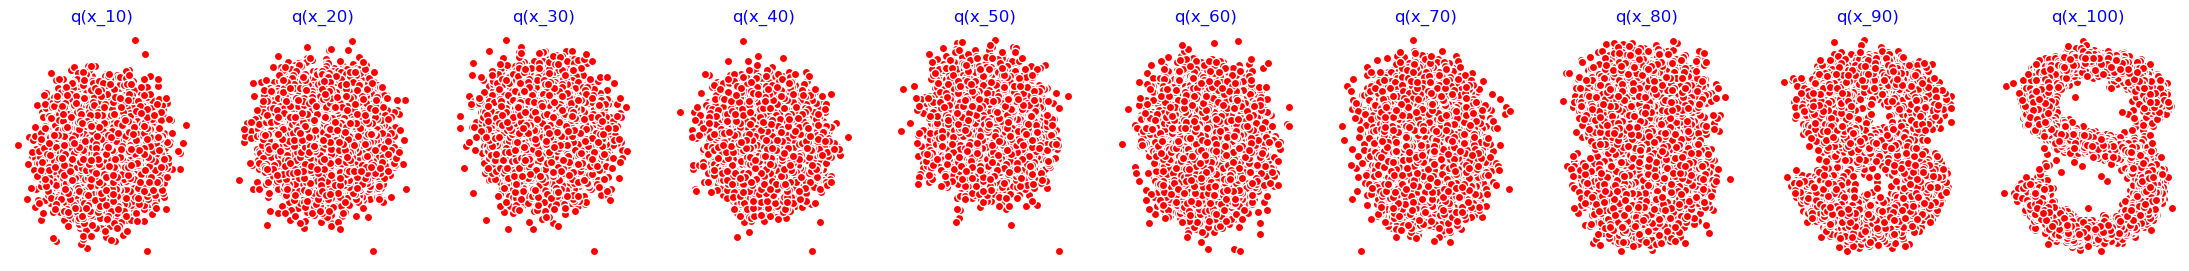

tensor(0.1162, grad_fn=<MeanBackward0>)


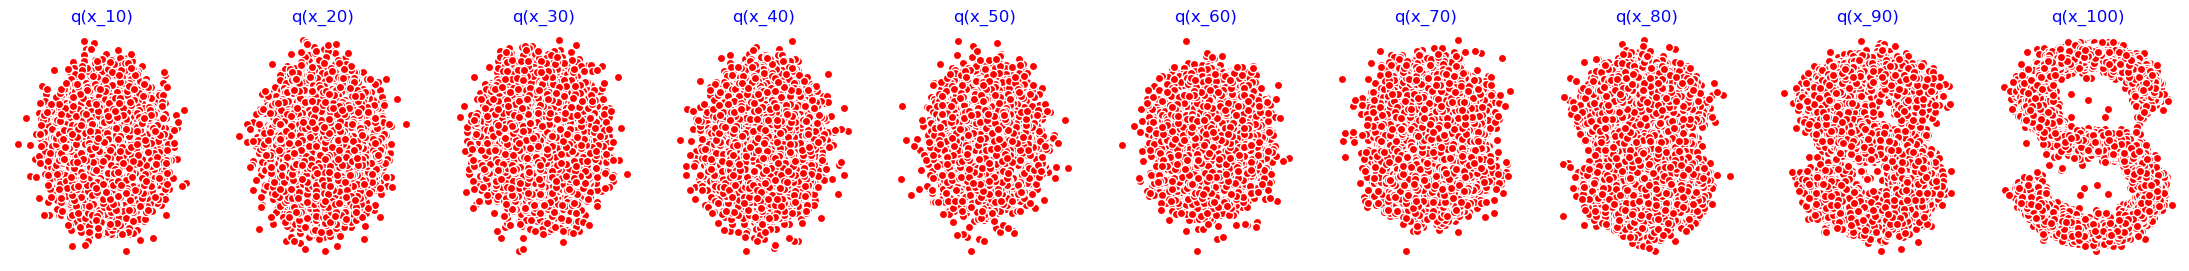

tensor(0.2079, grad_fn=<MeanBackward0>)


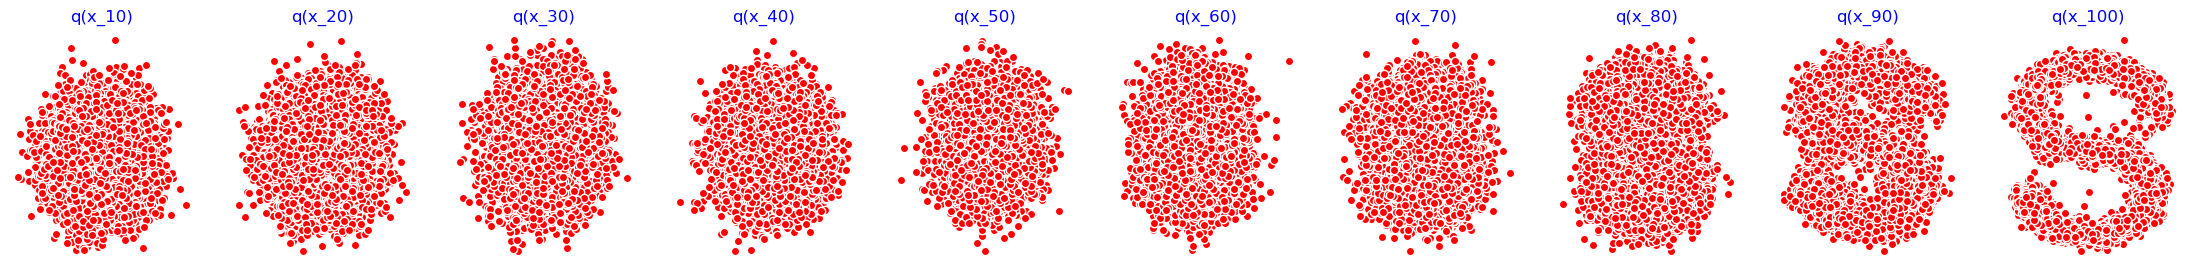

tensor(0.2703, grad_fn=<MeanBackward0>)


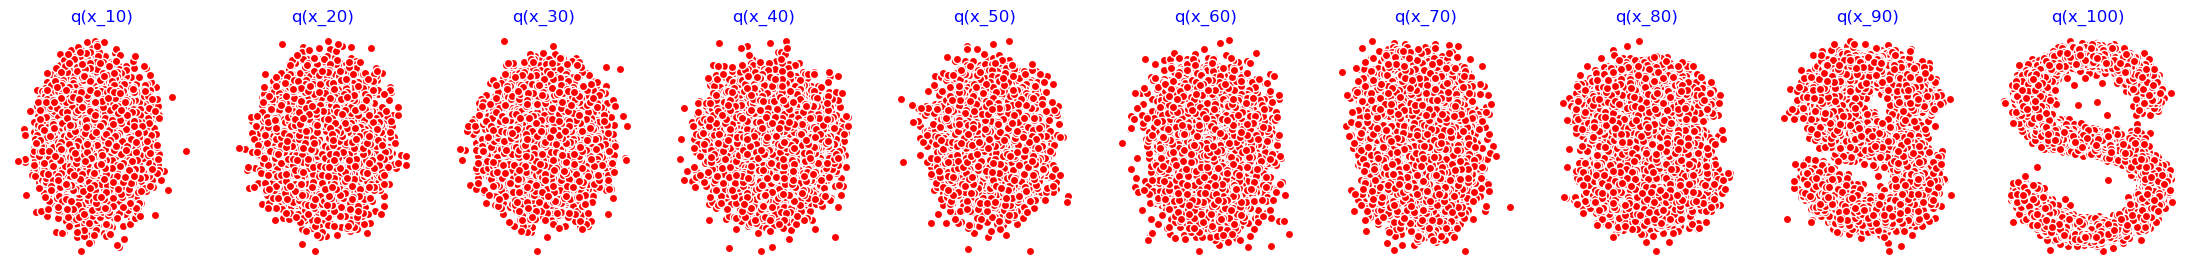

tensor(0.2193, grad_fn=<MeanBackward0>)


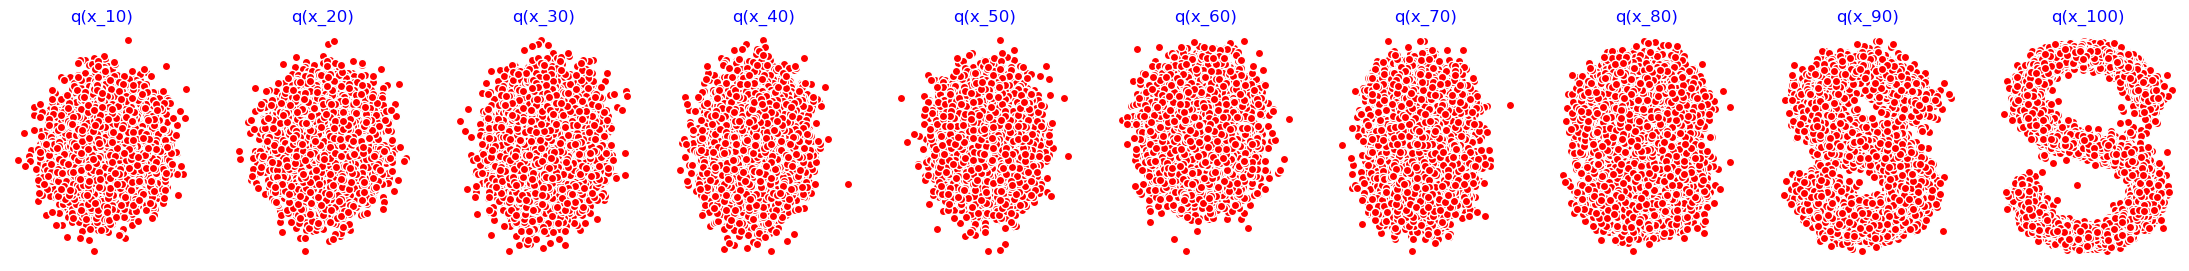

tensor(0.2932, grad_fn=<MeanBackward0>)


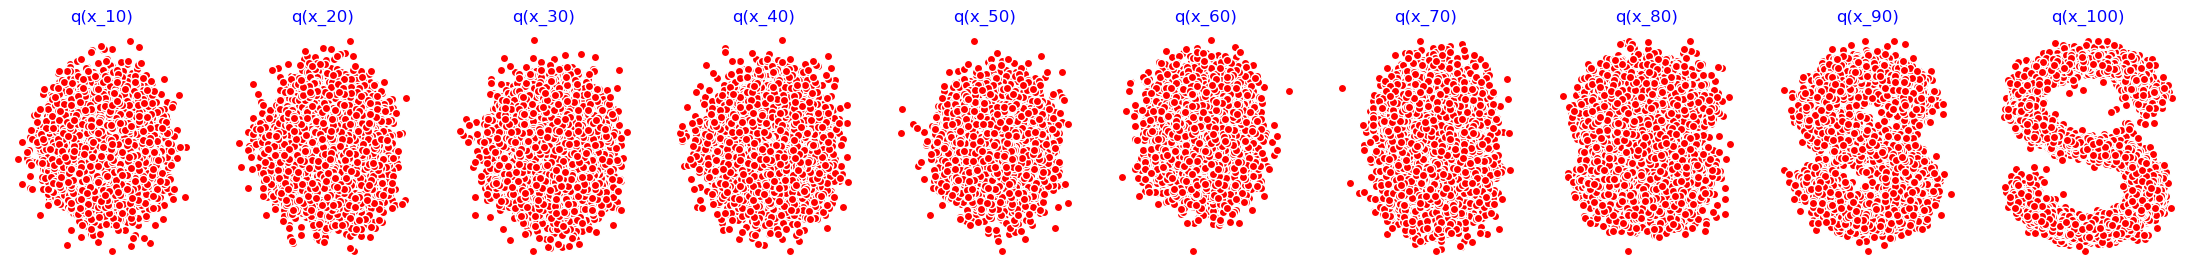

tensor(0.2659, grad_fn=<MeanBackward0>)


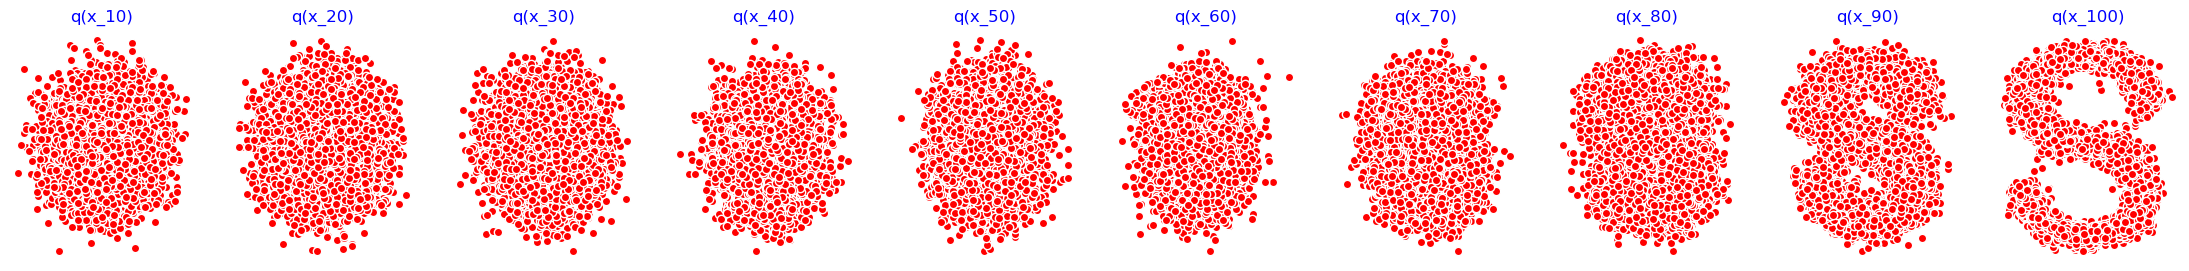

tensor(0.2786, grad_fn=<MeanBackward0>)


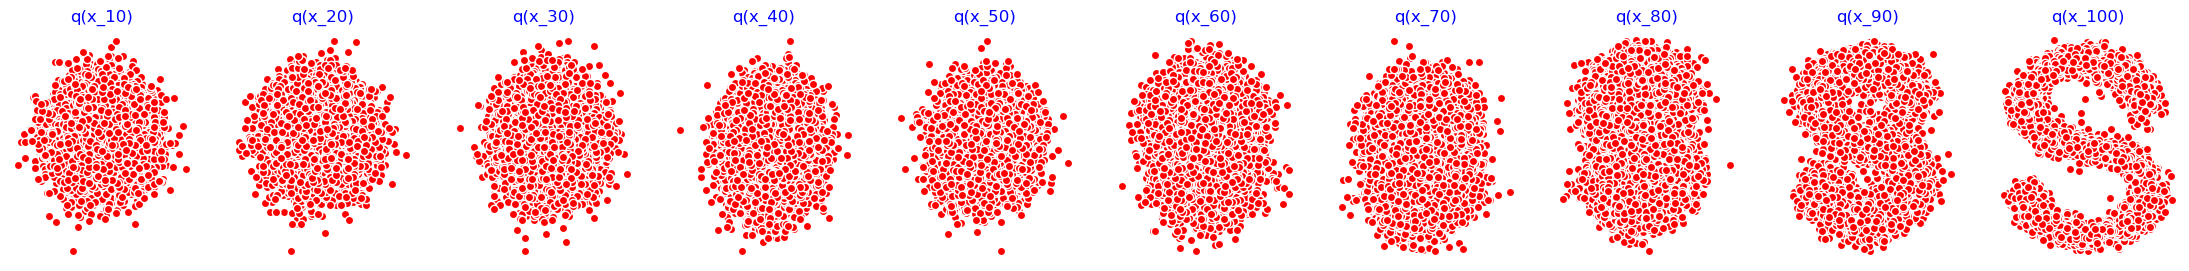

tensor(0.2430, grad_fn=<MeanBackward0>)


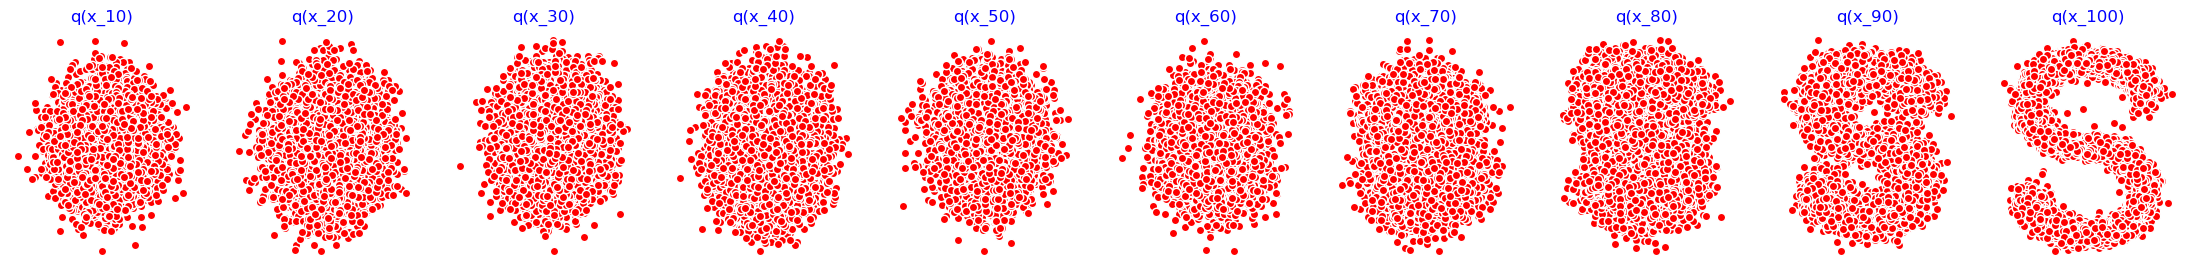

tensor(0.3204, grad_fn=<MeanBackward0>)


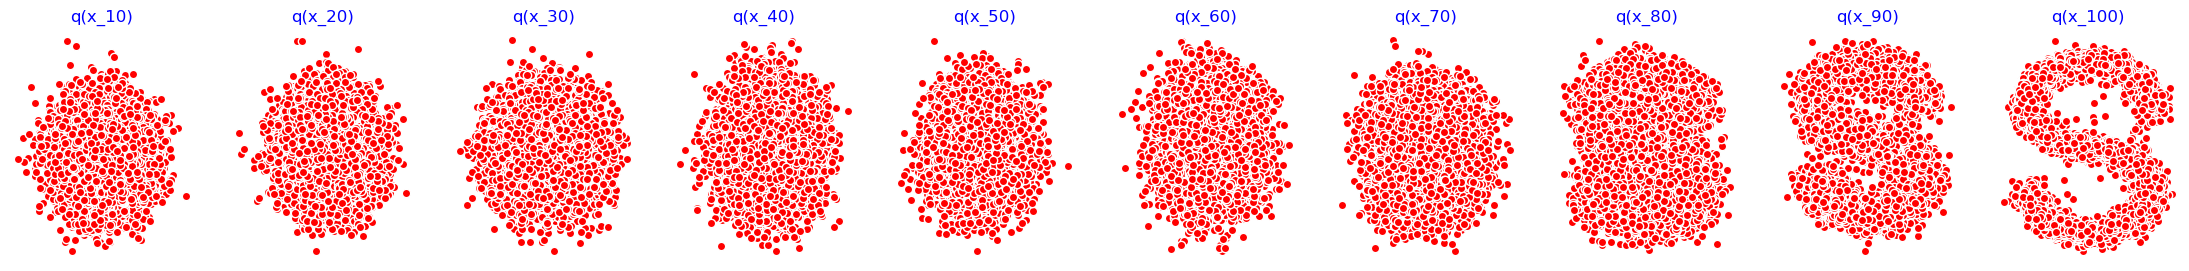

tensor(0.1993, grad_fn=<MeanBackward0>)


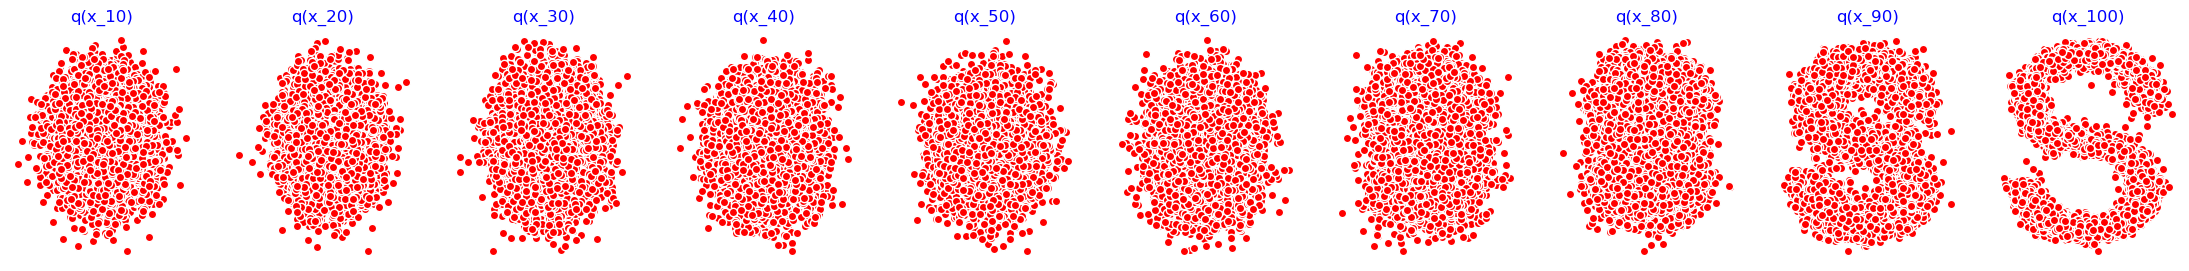

tensor(0.7571, grad_fn=<MeanBackward0>)


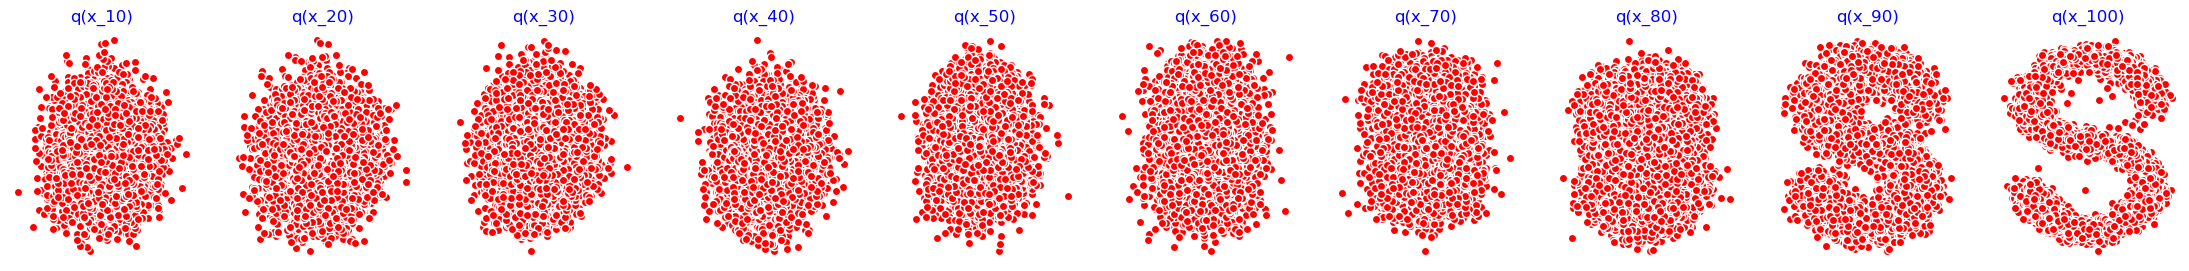

tensor(0.2546, grad_fn=<MeanBackward0>)


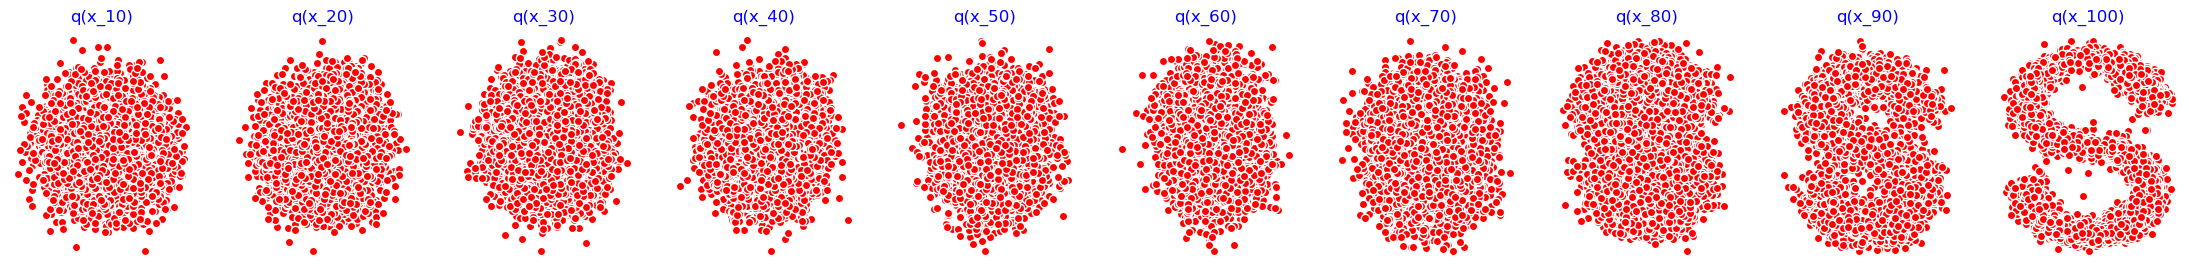

tensor(0.3836, grad_fn=<MeanBackward0>)


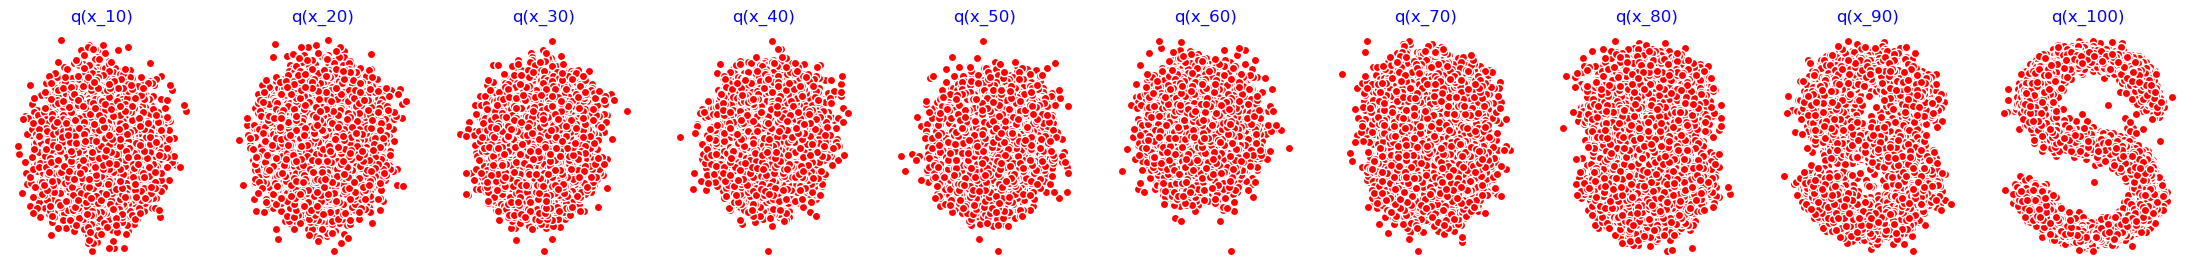

tensor(0.2450, grad_fn=<MeanBackward0>)


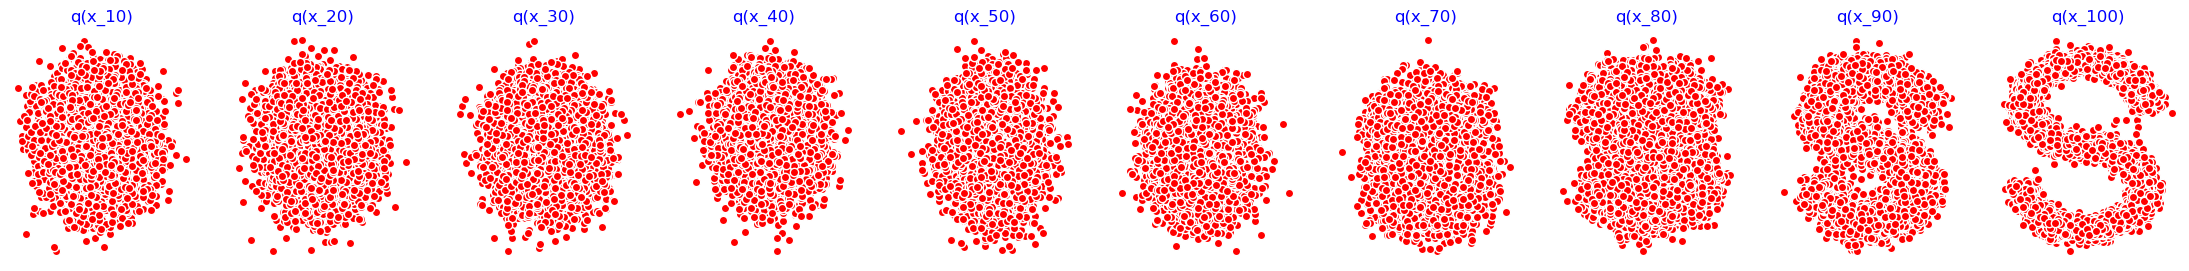

tensor(0.2283, grad_fn=<MeanBackward0>)


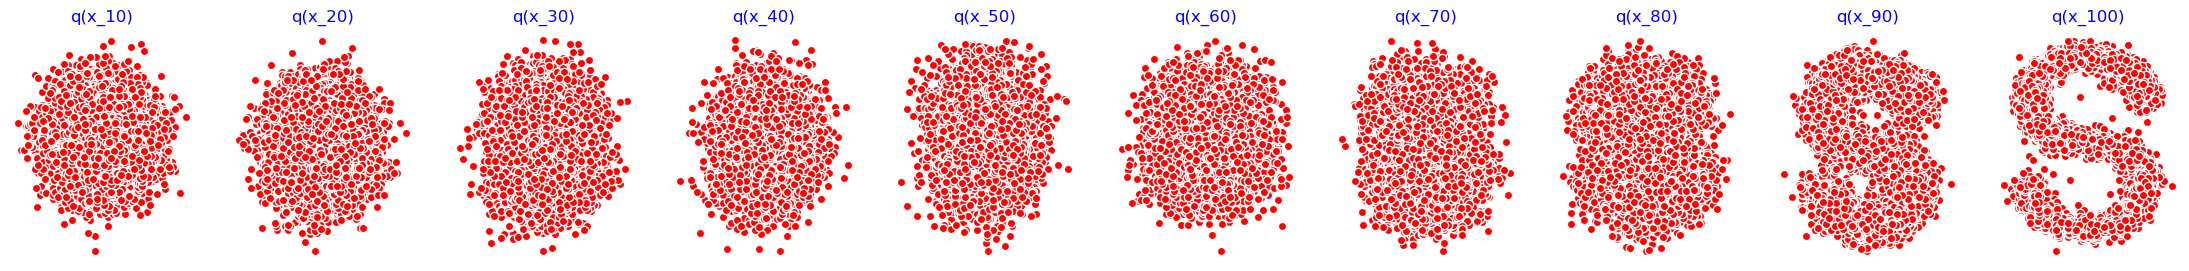

In [17]:
seed = 1234

class EMA():
    """构造一个参数平滑器"""
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print("Training model ...")

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc("text", color="blue")

model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        # 对梯度进行一个 clip，保持稳定性
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    # print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)  # 共有100个元素

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title(f'q(x_{str(i*10)})')

        plt.show()
        plt.close()

9. 动画演示扩散过程和逆扩散过程

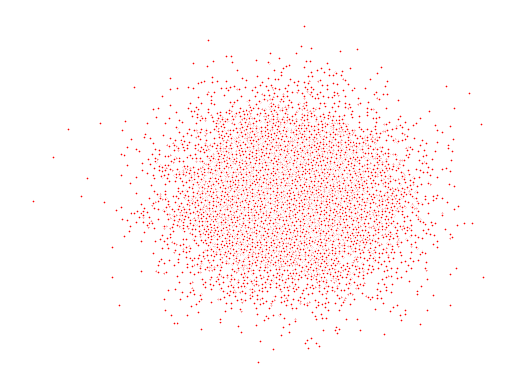

In [33]:
# Generating the forward image sequence 前向扩散过程

import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1], color="red", edgecolor="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="png")
    img = Image.open(img_buf)
    imgs.append(img)

plt.show()
plt.close()
imgs[0].save("diffusion-1.gif", format="GIF", append_images=imgs, save_all=True, duration=100, loop=0)

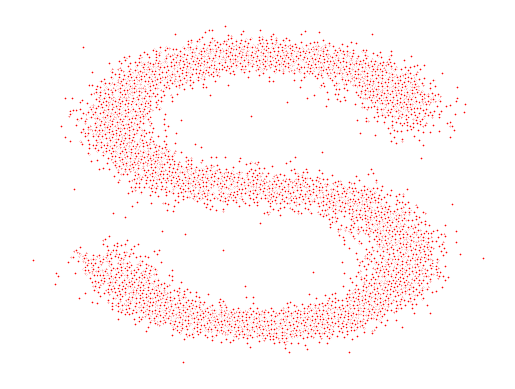

In [34]:
# Generating the reverse diffusion sequence 逆向生成过程

reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()  # 拿到训练末尾阶段生成的x_seq
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color="red", edgecolor="white", s=5)
    plt.axis("off")

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="png")
    img = Image.open(img_buf)
    reverse.append(img)

plt.show()
plt.close()
reverse[0].save("diffusion-2.gif", format="GIF", append_images=reverse, save_all=True, duration=100, loop=0)